<a href="https://colab.research.google.com/github/mnansary/pyF2O/blob/master/colab_gen_manNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colab specific task
*   mount google drive
*   change working directory to git repo
*   Check TF version
*    TPU check



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My\ Drive/PROJECTS/F2O/pyF2O

/content/gdrive/My Drive/PROJECTS/F2O/pyF2O


In [0]:
!pip3 install tensorflow==1.13.1

## TPU Check

In [4]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

tf.__version__

TPU address is grpc://10.89.44.202:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 158130094781230494),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2271453469138602302),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8992534795676828576),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5272453975527956165),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15866929967926059721),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 4833514300863849293),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 8012910824252317233),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 10535885469190820447),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 876846260408148

'1.13.1'

# manNet generator Model Training

## Compile Model

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_absolute_error
import sys
sys.path.append("..")
from core.generators import man_net
model=man_net()
model.summary()
model.compile(optimizer=Adam(lr=0.01), loss=mean_absolute_error)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

## Convert Model

In [6]:
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

def convert_model_TPU(model):
  return tf.contrib.tpu.keras_to_tpu_model(model,
                                           strategy=tf.contrib.tpu.TPUDistributionStrategy(
                                               tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
                                               )
                                           )

model=convert_model_TPU(model)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.89.44.202:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 158130094781230494)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 2271453469138602302)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8992534795676828576)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, 

## Data
* Load **X_Train_ALL.h5** and **Y_Train_ALL.h5**
* Normalize both dataset as float32
* Split the data for **validation** and **training**
* Drop Batch Reminders


In [7]:
from core.utils import readh5
import os
import numpy as np
from sklearn.model_selection import train_test_split  

class TRAIN_FLAGS:
    H5_DIR   = '/content/gdrive/My Drive/PROJECTS/F2O/H5Data/' # @param
    BATCH_SIZE      = 128  # @param
    NUM_EPOCHS      = 500  # @param
    IMAGE_DIM       = 128  # @param
    X_IDEN          = 'X_Train_ALL.h5'  # @param
    Y_IDEN          = 'Y_Train_ALL.h5'  # @param

X=readh5(os.path.join(TRAIN_FLAGS.H5_DIR,TRAIN_FLAGS.X_IDEN))
Y=readh5(os.path.join(TRAIN_FLAGS.H5_DIR,TRAIN_FLAGS.Y_IDEN))
# Normalize
X=X.astype('float32')/255.0
Y=Y.astype('float32')/255.0
# Test And Validation
Xt,Xv,Yt,Yv=train_test_split(X,Y,test_size=0.2)

print("Before Drop")
print("X_train: {}".format(Xt.shape))
print("Y_train: {}".format(Yt.shape))
print("X_eval: {}".format(Xv.shape))
print("Y_eval: {}".format(Yv.shape))

# Drop Batch Residue
nb_sig_train=int(Xt.shape[0]/TRAIN_FLAGS.BATCH_SIZE)*TRAIN_FLAGS.BATCH_SIZE 
nb_sig_eval=int(Xv.shape[0]/TRAIN_FLAGS.BATCH_SIZE)*TRAIN_FLAGS.BATCH_SIZE 

Xt=Xt[:nb_sig_train,:,:,:]
Yt=Yt[:nb_sig_train,:,:,:]
Xv=Xv[:nb_sig_eval,:,:,:]
Yv=Yv[:nb_sig_eval,:,:,:]

print("After Drop")
print("X_train: {}".format(Xt.shape))
print("Y_train: {}".format(Yt.shape))
print("X_eval: {}".format(Xv.shape))
print("Y_eval: {}".format(Yv.shape))


Before Drop
X_train: (4480, 128, 128, 3)
Y_train: (4480, 128, 128, 3)
X_eval: (1120, 128, 128, 3)
Y_eval: (1120, 128, 128, 3)
After Drop
X_train: (4480, 128, 128, 3)
Y_train: (4480, 128, 128, 3)
X_eval: (1024, 128, 128, 3)
Y_eval: (1024, 128, 128, 3)


## Train

In [8]:
history=model.fit(Xt,Yt,validation_data=(Xv,Yv),epochs=TRAIN_FLAGS.NUM_EPOCHS,batch_size=TRAIN_FLAGS.BATCH_SIZE, verbose=1)

Train on 4480 samples, validate on 1024 samples
Epoch 1/500
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float32, name='conv2d_25_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.009999999776482582, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for input_1
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fcdeba65b70> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 48.515430212020874 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU l

## Save Model Weights

In [9]:
model.save_weights(os.path.join(os.getcwd(),'core','model_weights','manNet.h5'))

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.009999999776482582
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False


## Plot Training Histoty

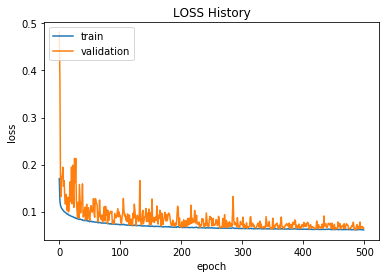

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')